# Research Notebook 

## The goal

The goal here is to understand the impact that data gaps have on the L01 pipeline. As seen, the impact of gaps on the telemetry variables result in a widening of the data gaps in the overall Michelson-like variables. I want to try and understand 

* What type of data gap is most impacted
* What generation of TDI is most impactful
* What do the data gap widening depend on? 
* Can I build a distribution of data gaps?

In [29]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from lisaconstants import TROPICALYEAR_J2000DAY
from tqdm import tqdm as tqdm
data_direc = "../data_for_simulations"
from LISA_artefacts import GapMaskGenerator

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Widening of the gap due to delays
## The $\eta$ variables

Now in the next cell we are going to verify our formula for the widening of the eta variables

In [16]:
def gap_augmentation_expression(lagrange_order,N_nans,delay,delay_number = 1.0):
    """
    Function to compute the gap augmentation from telemetry to eta variables
    """

    # Set up end points
    B_1 = 1 + 2*np.floor(delay_number * delay) - 2*N_nans
    B_2 = 2 * np.floor(delay_number * delay) - 1

    if 1 < lagrange_order <= B_1:
        # Clause 1
        extra_widening = lagrange_order + N_nans
    elif B_1 <  lagrange_order <= B_2 :
        # Clause 2
        extra_widening = (lagrange_order+ 1)/2 + np.floor(delay_number * delay)
    elif lagrange_order > B_2:
        # Clause 3
        extra_widening = lagrange_order

    return int(extra_widening), int(N_nans + extra_widening) 

def widening_gap_X1(lagrange_order,N_nans,delay):
    """
    Function to compute the gap augmentation from eta variables to X1 variables
    """
    
    _, total_nans_eta = gap_augmentation_expression(lagrange_order,N_nans,delay,delay_number = 1) # eta variables
    _, total_nans_a12 = gap_augmentation_expression(lagrange_order,total_nans_eta,delay,delay_number = 1)
    widening_r12, total_nans_X1 = gap_augmentation_expression(lagrange_order,total_nans_a12,delay,delay_number = 2)

    return widening_r12, total_nans_X1

def widening_gap_X2(lagrange_order,N_nans,delay):
    """
    Function to compute the gap augmentation from X1 variables to X2 variables
    """

    _, total_nans_X1 = widening_gap_X1(lagrange_order,N_nans,delay) # X1 variables
    widening_q12, total_nans_X2 = gap_augmentation_expression(lagrange_order,total_nans_X1,delay,delay_number = 4.0) # X2 variables

    return widening_q12, total_nans_X2

def widening_gap_X1_unfactorized(lagrange_order,N_nans,delay):
    _, total_nans_eta = gap_augmentation_expression(lagrange_order,N_nans,delay,delay_number = 1) # eta variables
    widening_X1_unfactorized, total_nans_X1_unfactorized = gap_augmentation_expression(lagrange_order,total_nans_eta,delay,delay_number = 3.0)
    return widening_X1_unfactorized, total_nans_X1_unfactorized

def widening_gap_X2_unfactorized(lagrange_order,N_nans,delay):
    _, total_nans_eta = gap_augmentation_expression(lagrange_order,N_nans,delay,delay_number = 1) # eta variables
    widening_X1_unfactorized, total_nans_X1_unfactorized = gap_augmentation_expression(lagrange_order,total_nans_eta,delay,delay_number = 7.0)
    return widening_X1_unfactorized, total_nans_X1_unfactorized



In [17]:
import numpy as np

def gap_augmentation_expression(lagrange_order, N_nans, delay, delay_number=1.0):
    """
    Compute the gap augmentation from telemetry to eta variables.
    Returns:
        extra_widening: amount of widening from interpolation
        total_nans: N_nans plus extra_widening
    """
    D = np.floor(delay_number * delay)
    B_1 = 1 + 2 * D - 2 * N_nans
    B_2 = 2 * D - 1

    if 1 < lagrange_order <= B_1:
        extra_widening = lagrange_order + N_nans
    elif lagrange_order <= B_2:
        extra_widening = (lagrange_order + 1) / 2 + D
    else:
        extra_widening = lagrange_order

    return extra_widening, N_nans + extra_widening


def _cascade_widening(lagrange_order, initial_nans, delay, delay_numbers):
    """
    Apply multiple stages of gap widening given a sequence of delay_numbers.
    Returns the final widening and total_nans.
    """
    nans = initial_nans
    for d_num in delay_numbers[:-1]:
        _, nans = gap_augmentation_expression(lagrange_order, nans, delay, delay_number=d_num)
    return gap_augmentation_expression(lagrange_order, nans, delay, delay_number=delay_numbers[-1])


def widening_gap_X1(lagrange_order, N_nans, delay):
    """
    Compute gap augmentation from eta to X1 variables.
    """
    return _cascade_widening(lagrange_order, N_nans, delay, [1, 1, 2])


def widening_gap_X2(lagrange_order, N_nans, delay):
    """
    Compute gap augmentation from X1 to X2 variables (fully factorized).
    """
    _, total_nans_X1 = widening_gap_X1(lagrange_order, N_nans, delay)
    return gap_augmentation_expression(lagrange_order, total_nans_X1, delay, delay_number=4.0)


def widening_gap_X1_unfactorized(lagrange_order, N_nans, delay):
    """
    Compute gap augmentation from eta to X1 variables (unfactorized).
    """
    return _cascade_widening(lagrange_order, N_nans, delay, [1, 3])


def widening_gap_X2_unfactorized(lagrange_order, N_nans, delay):
    """
    Compute gap augmentation from eta to X2 variables (unfactorized).
    """
    return _cascade_widening(lagrange_order, N_nans, delay, [1, 7])


In [20]:
# Set up lolipops pipeline
from pathlib import Path
import yaml
import logging

from lolipops.conventions import MOSAS
from lolipops.constellation.tdi import (
    compute_factorized_intervars,
    compute_factorized_michelson,
)
from lolipops.local import ifo, prn

from lolipops.io import read_telemetry_from_instrument, read_ground_tracking, Sampling

logging.basicConfig(level=logging.INFO)
logging.getLogger("pytdi").setLevel(logging.WARNING)

telemetry_file = data_direc + "/instru.h5"
ground_tracking_file = data_direc + "/groundtrack.h5"

telemetry, instrument_knowledge = read_telemetry_from_instrument(telemetry_file)
ground_tracking = read_ground_tracking(ground_tracking_file, telemetry_file)

orbits_file = data_direc + "/orbits.h5"

# Configuration file
config_file = data_direc + "/config.yaml"

with Path(config_file).open("r") as file:
    config_dict = yaml.safe_load(file)

INFO:lolipops.io:Loading telemetry from LISA Instrument file '../data_for_simulations/instru.h5'


INFO:lolipops.io:Loading ground tracking data from '../data_for_simulations/groundtrack.h5'


In [21]:
# Telemetry data and apply group delay corrections
ifos = telemetry.ifos
prns = telemetry.prns

# Group delay correction
corrected_ifos = ifo.cancel_filter_group_delay(
    ifos, telemetry.sampling, telemetry.instrument_knowledge
)
corrected_prns = prn.cancel_filter_group_delay(
    prns, telemetry.sampling, telemetry.instrument_knowledge
)


# Compute the measured pseudo ranges (light travel times)
mprs = corrected_prns

# Compute the various derivatives
mpr_derivatives = {
    mosa: np.gradient(mprs[mosa], telemetry.sampling.dt) for mosa in MOSAS
}

lagrange_order_eta_gap = 45

INFO:lolipops.local.ifo:Cancelling filter group delay for interferometric beatnotes


INFO:lolipops.local.prn:Canceling filter group delay for PRN measurements


Lost out on approximately 0.0013888888888888887 hours of data
This ammounts to 20 number of samples


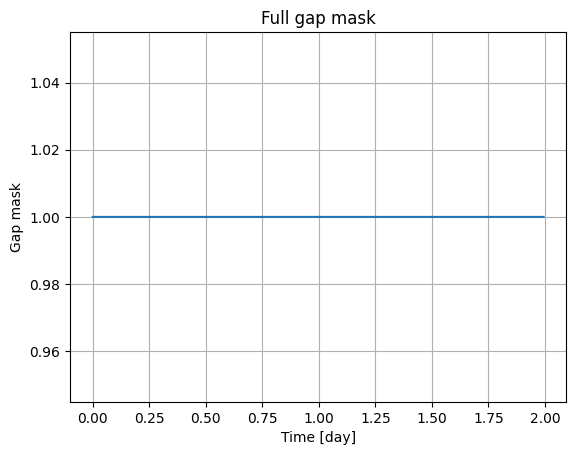

In [23]:
# Construct gap class

def construct_mask_single_gap(N_nans, length = None):
    masking_function = np.ones(length)
    mid_index = int(len(masking_function) / 2)
    masking_function[mid_index : mid_index + N_nans] = np.nan
    return masking_function

CONTROL_NANS = True
GAP_CLASS = False

N = telemetry.sampling.size
t_start = telemetry.sampling.t0

sim_t = np.arange(0, N * telemetry.sampling.dt, telemetry.sampling.dt)


N_tel_nans= 20
if CONTROL_NANS:
    masking_function = construct_mask_single_gap(N_tel_nans, length = N)


plt.plot(sim_t / 60 / 60 / 24, masking_function)
plt.title("Full gap mask")
plt.xlabel("Time [day]")
plt.ylabel("Gap mask")
plt.grid(True)

print(
    "Lost out on approximately",
    np.sum(np.isnan(masking_function)) * 0.25 / 60 / 60,
    "hours of data",
)
print(
    "This ammounts to {} number of samples".format(np.sum(np.isnan(masking_function)))
)

In [30]:
def nanify_telemetry_variables(telemetry, masking_function, plot_data = False):
    # Place the gaps in the telemetry variables
    import copy

    # Make a copy of the telemetric data variables
    telemetry_w_gaps = copy.deepcopy(telemetry)

    # idx_start_gap = np.argwhere(np.isnan(masking_function) == True)[0][0]
    # idx_end_gap = np.argwhere(np.isnan(masking_function) == True)[-1][-1]


    # print("Starting and ending indices of the gap in the telemetry data:")
    # print(idx_start_gap, idx_end_gap)

    tmi_label = [f"tmi_{mosa}" for mosa in MOSAS]
    rfi_label = [f"rfi_{mosa}" for mosa in MOSAS]
    rfi_usb_label = [f"rfi_usb_{mosa}" for mosa in MOSAS]
    isi_label = [f"isi_{mosa}" for mosa in MOSAS]
    isi_usb_label = [f"isi_usb_{mosa}" for mosa in MOSAS]

    for tmi_item, rfi_item, rfi_usb_item, isi_item, isi_usb_item in zip(
        tmi_label, rfi_label, rfi_usb_label, isi_label, isi_usb_label
    ):
        telemetry_w_gaps.ifos[tmi_item] = (
            telemetry.ifos[tmi_item] * masking_function
        )  # No delays in each of these.
        telemetry_w_gaps.ifos[rfi_item] = (
            telemetry.ifos[rfi_item] * masking_function
        )  # No delays in each of these.
        telemetry_w_gaps.ifos[rfi_usb_item] = (
            telemetry.ifos[rfi_usb_item] * masking_function
        )  # No delays in each of these.
        telemetry_w_gaps.ifos[isi_item] = (
            telemetry.ifos[isi_item] * masking_function
        )  # No delays in each of these.
        telemetry_w_gaps.ifos[isi_usb_item] = (
            telemetry.ifos[isi_usb_item] * masking_function
        )  # No delays in each of these.

    mprs_w_nans = copy.deepcopy(mprs)
    mpr_derivatives_w_nans = copy.deepcopy(mpr_derivatives)
    for mosa in MOSAS:
        mprs_w_nans[mosa] = masking_function * mprs[mosa]
        mpr_derivatives_w_nans[mosa] = masking_function * mprs[mosa]

    return telemetry_w_gaps, mprs_w_nans, mpr_derivatives_w_nans

In [31]:
N_nans = 200000
order = 27
masking_function = construct_mask_single_gap(N_nans, length = N)
telemetry_w_gaps, mprs_w_nans, mpr_derivatives_w_nans = nanify_telemetry_variables(telemetry, masking_function, plot_data = False)
etas_w_gaps_nans = compute_factorized_intervars(
    telemetry_w_gaps.ifos,
    mprs_w_nans,
    mpr_derivatives_w_nans,
    telemetry.sampling,
    lagrange_interp_order=order,
)

N_nans_in_eta_lolipops = np.sum(np.isnan(etas_w_gaps_nans["eta_12"]))
widening_gap_eta_lolipops = N_nans_in_eta_lolipops - N_nans
print("Number of nans in the eta variables = ", N_nans_in_eta_lolipops)
print("Overall widening of gap in eta variables = ", widening_gap_eta_lolipops)

INFO:lolipops.constellation.tdi:Computing factorized intermediary variables
/Users/ollie.burke/Library/Caches/pypoetry/virtualenvs/lolipops-xCMWH5ZF-py3.12/lib/python3.12/site-packages/pytdi/dsp.py:113: RuntimeWarning: invalid value encountered in cast
  shift_ints = shift_ints.astype(int)


Number of nans in the eta variables =  200047
Overall widening of gap in eta variables =  47


In [26]:
# Check formula

delay = 8.3333/0.25 # Here we take the mean LTT. 

widening_gap_eta_theory, N_nans_in_eta_theory = gap_augmentation_expression(order, N_nans, delay, delay_number=1.0)
print("Number of nans in the eta variables = ", N_nans_in_eta_theory)
print("Overall widening of gap in eta variables = ", widening_gap_eta_theory)


Number of nans in the eta variables =  200047.0
Overall widening of gap in eta variables =  47.0


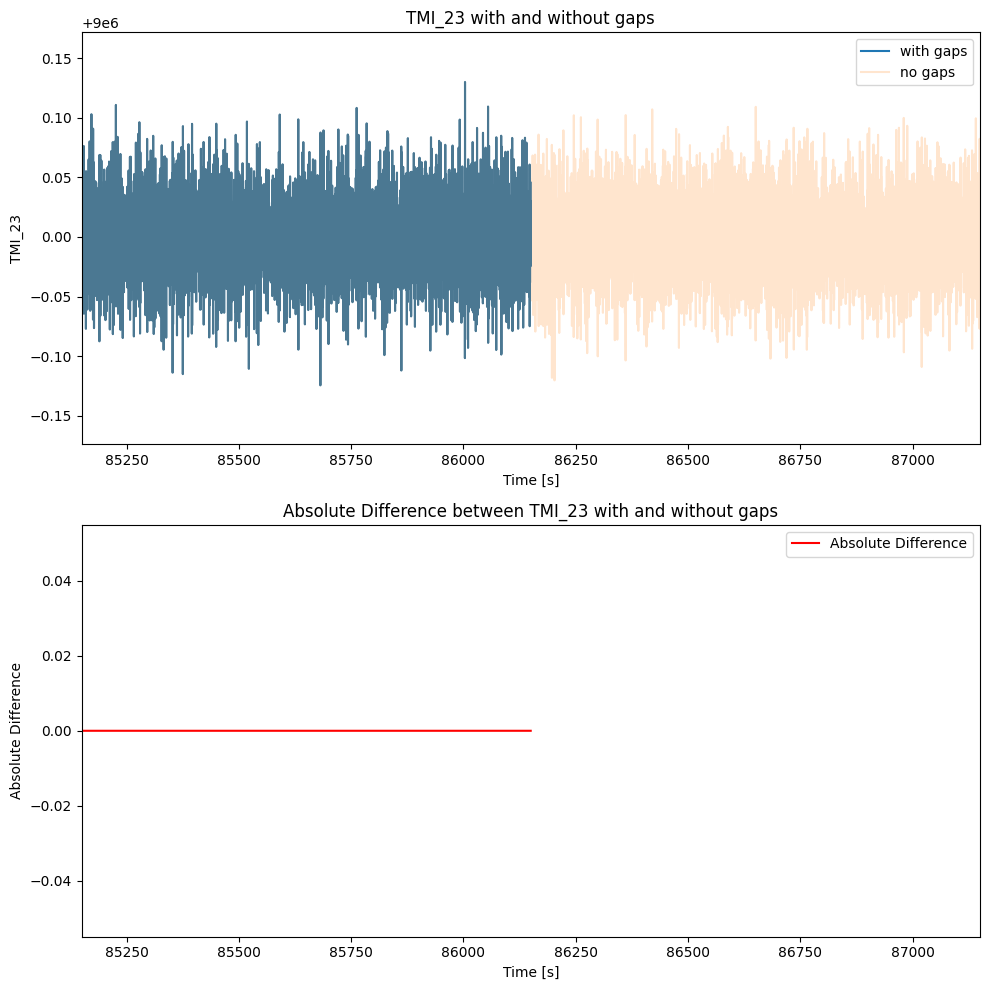

In [27]:
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

idx_start_gap = np.argwhere(np.isnan(masking_function) == True)[0][0]
idx_end_gap = np.argwhere(np.isnan(masking_function) == True)[-1][-1]
# First subplot: Original plot with gaps and no gaps
axs[0].plot(sim_t, telemetry_w_gaps.ifos["tmi_23"], label="with gaps", alpha=1)
axs[0].plot(sim_t, telemetry.ifos["tmi_23"], label="no gaps", alpha=0.2)
axs[0].set_xlim([sim_t[idx_start_gap] - 1000, sim_t[idx_start_gap] + 1000])
axs[0].set_ylabel(r"TMI_23")
axs[0].set_xlabel("Time [s]")
axs[0].legend()
axs[0].set_title("TMI_23 with and without gaps")

# Second subplot: Absolute difference between the two
absolute_difference = np.abs(telemetry_w_gaps.ifos["tmi_23"] - telemetry.ifos["tmi_23"])
axs[1].plot(sim_t, absolute_difference, label="Absolute Difference", color="red")
axs[1].set_xlim([sim_t[idx_start_gap] - 1000, sim_t[idx_start_gap] + 1000])
axs[1].set_ylabel("Absolute Difference")
axs[1].set_xlabel("Time [s]")
axs[1].legend()
axs[1].set_title("Absolute Difference between TMI_23 with and without gaps")

plt.tight_layout()
plt.show()

In [32]:
order = 45
results_testing_N_nans = []
N_nans_in_telem_values = np.logspace(0, 2, num=50, dtype=int)  # Logarithmic spacing from 1 to 10000

for N_nans in tqdm(N_nans_in_telem_values):
    # Construct masking function
    masking_function = construct_mask_single_gap(N_nans, length=N)
        
    # Generate telemetry with gaps
    telemetry_w_gaps, mprs_w_nans, mpr_derivatives_w_nans = nanify_telemetry_variables(
        telemetry, masking_function, plot_data=False
    )
        
    # Compute eta variables with gaps
    etas_w_gaps_nans = compute_factorized_intervars(
        telemetry_w_gaps.ifos,
        mprs_w_nans,
        mpr_derivatives_w_nans,
        telemetry.sampling,
        lagrange_interp_order=order,
    )
        
    # Calculate N_nans and widening for lolipops
    N_nans_in_eta_lolipops = np.sum(np.isnan(etas_w_gaps_nans["eta_12"]))
    widening_gap_eta_lolipops = N_nans_in_eta_lolipops - N_nans
        
    # Calculate N_nans and widening for theoretical model
    widening_gap_eta_theory, N_nans_in_eta_theory = gap_augmentation_expression(
        order, N_nans, delay, delay_number=1
    )
        
    # Append results to the list
    results_testing_N_nans.append({
        "N_nans": N_nans,
        "N_nans_in_eta_lolipops": N_nans_in_eta_lolipops,
        "N_nans_in_eta_theory": N_nans_in_eta_theory,
        "widening_gap_eta_lolipops": widening_gap_eta_lolipops,
        "widening_gap_eta_theory": widening_gap_eta_theory
    })
    

100%|██████████| 50/50 [03:03<00:00,  3.68s/it]


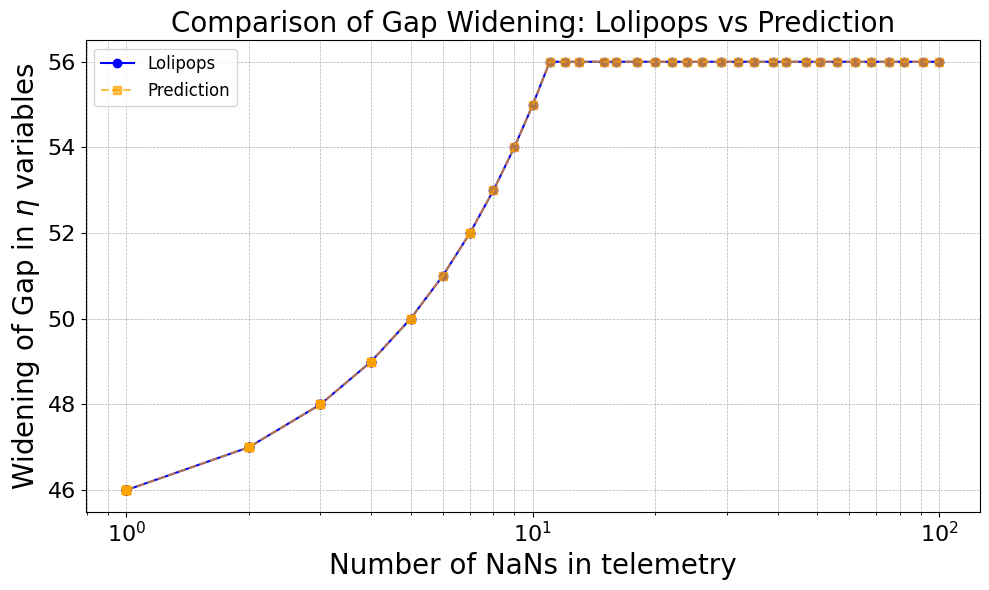

In [190]:
# Plot the results of the above cell

import matplotlib.pyplot as plt
import numpy as np

# Extract data from results
N_nans_in_telem_values = [result["N_nans"] for result in results_testing_N_nans]
widening_gap_eta_lolipops = [result["widening_gap_eta_lolipops"] for result in results_testing_N_nans]
widening_gap_eta_theory = [result["widening_gap_eta_theory"] for result in results_testing_N_nans]

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(N_nans_in_telem_values, widening_gap_eta_lolipops, label="Lolipops", marker="o", linestyle="-", color="blue")
plt.plot(N_nans_in_telem_values, widening_gap_eta_theory, label="Prediction", marker="s", linestyle="--", color="orange", alpha = 0.7)

# Add labels, legend, and grid
plt.xscale("log")
plt.xlabel("Number of NaNs in telemetry", fontsize=20)
plt.ylabel(r"Widening of Gap in $\eta$ variables", fontsize=20)
plt.title("Comparison of Gap Widening: Lolipops vs Prediction", fontsize=20)
plt.legend(fontsize=12)

# Increase tick sizes
plt.tick_params(axis="both", which="major", labelsize=16)

plt.grid(True, which="both", linestyle="--", linewidth=0.5)

# Save and show the plot
plt.tight_layout()
plt.savefig("gap_widening_comparison.png", dpi=300)  # Save as a high-resolution image
plt.show()

# What do we learn here?
## For large strings of missing data, gap augmentation is constant. 



In [39]:
results_by_order = {}

# Define the gap configurations and range of orders
gap_configurations = [1, 10, 100]
orders = range(25, 81,2)  # From 25 to 81 inclusive

# Loop over each gap configuration
for N_nans in gap_configurations:
    results_by_order[N_nans] = []  # Initialize results for this gap configuration
    
    for order in tqdm(orders):
        # Construct masking function
        masking_function = construct_mask_single_gap(N_nans, length=N)
        
        # Generate telemetry with gaps
        telemetry_w_gaps, mprs_w_nans, mpr_derivatives_w_nans = nanify_telemetry_variables(
            telemetry, masking_function, plot_data=False
        )
        
        # Compute eta variables with gaps
        etas_w_gaps_nans = compute_factorized_intervars(
            telemetry_w_gaps.ifos,
            mprs_w_nans,
            mpr_derivatives_w_nans,
            telemetry.sampling,
            lagrange_interp_order=order,
        )
        
        # Calculate N_nans and widening for lolipops
        N_nans_in_eta_lolipops = np.sum(np.isnan(etas_w_gaps_nans["eta_12"]))
        widening_gap_eta_lolipops = N_nans_in_eta_lolipops - N_nans
        
        # Calculate N_nans and widening for theoretical model
        widening_gap_eta_theory, N_nans_in_eta_theory = gap_augmentation_expression(
            order, N_nans, delay, delay_number=1
        )
        
        # Append results to the list for this gap configuration
        results_by_order[N_nans].append({
            "order": order,
            "N_nans_in_eta_lolipops": N_nans_in_eta_lolipops,
            "N_nans_in_eta_theory": N_nans_in_eta_theory,
            "widening_gap_eta_lolipops": widening_gap_eta_lolipops,
            "widening_gap_eta_theory": widening_gap_eta_theory
        })

  0%|          | 0/28 [00:00<?, ?it/s]INFO:lolipops.constellation.tdi:Computing factorized intermediary variables
/opt/homebrew/anaconda3/envs/lollipops_env/lib/python3.12/site-packages/pytdi/dsp.py:113: RuntimeWarning: invalid value encountered in cast
  shift_ints = shift_ints.astype(int)
100%|██████████| 28/28 [03:18<00:00,  7.08s/it]


<Figure size 640x480 with 0 Axes>

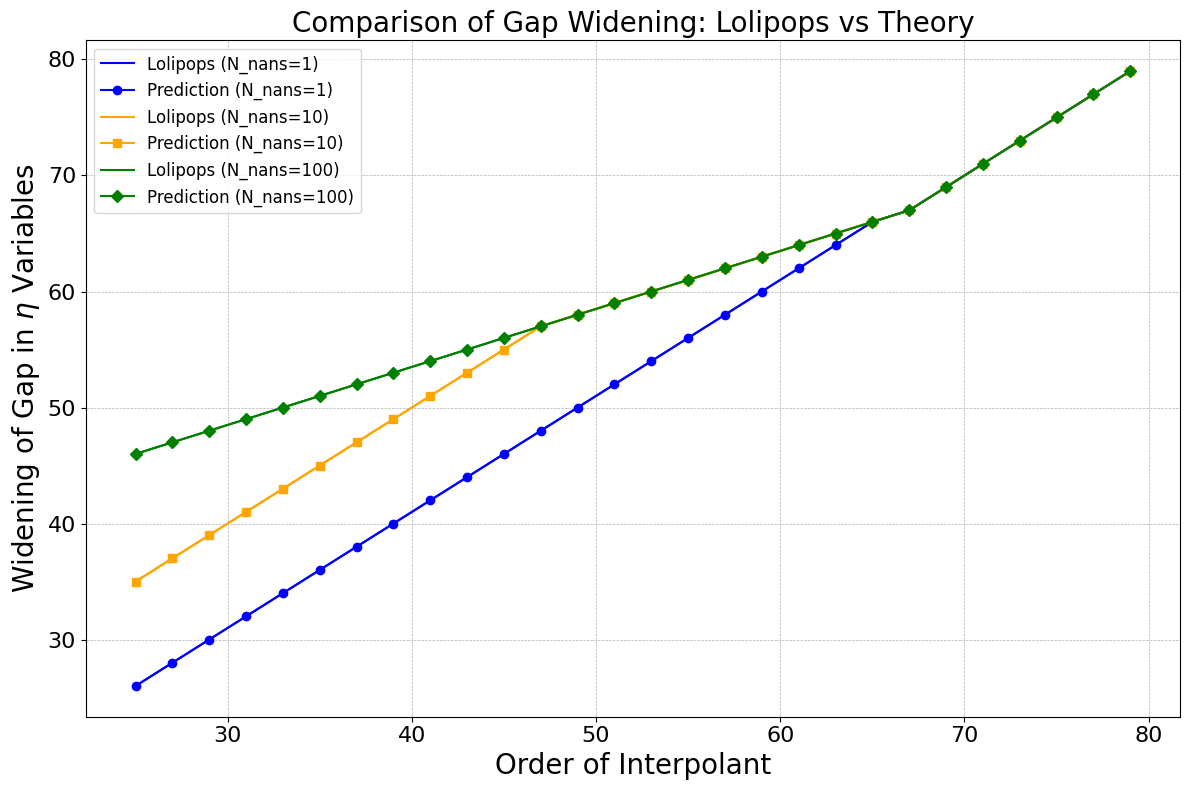

In [175]:
import matplotlib.pyplot as plt
plt.clf()
# Create a single plot for all gap configurations
plt.figure(figsize=(12, 8))

# Define markers and colors for each gap configuration
markers = ["o", "s", "D"]
colors = ["blue", "orange", "green"]

# Loop through each gap configuration and plot the results
for idx, (N_nans, results) in enumerate(results_by_order.items()):
    # Extract data for this N_nans configuration
    orders = [result["order"] for result in results]
    widening_gap_eta_lolipops = [result["widening_gap_eta_lolipops"] for result in results]
    widening_gap_eta_theory = [result["widening_gap_eta_theory"] for result in results]
    
    # Plot lolipops results (solid lines)
    plt.plot(
        orders, widening_gap_eta_lolipops, 
        label=f"Lolipops (N_nans={N_nans})", 
        linestyle="-", color=colors[idx], zorder=1
    )
    
    # Plot theoretical results (dashed lines)
    plt.plot(
        orders, widening_gap_eta_theory, 
        label=f"Prediction (N_nans={N_nans})", 
        marker=markers[idx], color=colors[idx], zorder=2
    )

# Add labels, legend, and grid
plt.xlabel("Order of Interpolant", fontsize=20)
plt.ylabel(r"Widening of Gap in $\eta$ Variables", fontsize=20)
plt.title("Comparison of Gap Widening: Lolipops vs Theory", fontsize=20)
plt.legend(fontsize=12, loc="upper left")
plt.grid(True, linestyle="--", linewidth=0.5)

# Increase tick sizes
plt.tick_params(axis="both", which="major", labelsize=16)

# Save and show the plot
plt.tight_layout()
plt.savefig("gap_widening_comparison_all_configs.png", dpi=300)  # Save as a high-resolution image
plt.show()

# Now let's try to do the same thing but with factorized variables

We have no shown that the widening of the gap in the $\eta$ variables is sensitive to three things:

* The number of consecutive missing data in the telemetry variables
* The integer delay used when computing the interpolation
* The order of the interpolant. 

However, the quantity that L2A and L2D are most interested in are the L1 data products. In other words, the laser-cleaned TDI combinations $X$, $Y$ and $Z$ for various generations of TDI. Below we will do a similar analysis but now considering the TDI variables. 



In [102]:
from tqdm import tqdm as tqdm
order = 45
results_TDI_testing_N_nans = []

N_nans_in_telem_values = np.logspace(0, 2, num=50, dtype=int)  # Logarithmic spacing from 1 to 10000

for N_nans in tqdm(N_nans_in_telem_values):
    # Construct masking function
    masking_function = construct_mask_single_gap(N_nans, length=N)
        
    # Generate telemetry with gaps
    telemetry_w_gaps, mprs_w_nans, mpr_derivatives_w_nans = nanify_telemetry_variables(
        telemetry, masking_function, plot_data=False
    )
        
    # Compute eta variables with gaps
    etas_w_gaps_nans = compute_factorized_intervars(
        telemetry_w_gaps.ifos,
        mprs_w_nans,
        mpr_derivatives_w_nans,
        telemetry.sampling,
        lagrange_interp_order=order,
    )
    TDI_X = []
    for gen in range(1,3):
        result = compute_factorized_michelson(
            etas_w_gaps_nans,
            mprs,
            mpr_derivatives,
            telemetry.sampling,
            generation=gen,
            lagrange_interp_order=order,
    )
        TDI_X.append(result["X"])
        
    # Calculate N_nans and widening for lolipops
    N_nans_in_TDI = [np.sum(np.isnan(TDI_X[i])) for i in range(len(TDI_X))]
    N_nans_in_X1_lolipops = N_nans_in_TDI[0] 
    N_nans_in_X2_lolipops = N_nans_in_TDI[1] 

    widening_gap_X1_lolipops = N_nans_in_X1_lolipops - N_nans
    widening_gap_X2_lolipops = N_nans_in_X2_lolipops - N_nans
        
    # Calculate N_nans and widening for theoretical model
    _, N_nans_in_X1_theory = widening_gap_X1(order, N_nans, delay)
    _, N_nans_in_X2_theory = widening_gap_X2(order, N_nans, delay)

    widening_gap_X1_theory = N_nans_in_X1_theory - N_nans
    widening_gap_X2_theory = N_nans_in_X2_theory - N_nans
        
    # Append results to the list
    results_TDI_testing_N_nans.append({
        "N_nans": N_nans,
        "N_nans_in_X1_lolipops": N_nans_in_X1_lolipops,
        "N_nans_in_X2_lolipops": N_nans_in_X2_lolipops,
        "widening_gap_X1_lolipops": widening_gap_X1_lolipops,
        "widening_gap_X2_lolipops": widening_gap_X2_lolipops,
        "N_nans_in_X1_theory": N_nans_in_X1_theory,
        "N_nans_in_X2_theory": N_nans_in_X2_theory,
        "widening_gap_X1_theory": widening_gap_X1_theory,
        "widening_gap_X2_theory": widening_gap_X2_theory
    })
    

  0%|          | 0/50 [00:00<?, ?it/s]

INFO:lolipops.constellation.tdi:Computing factorized intermediary variables
INFO:lolipops.constellation.tdi:Computing factorized second-generation Michelson variables
INFO:lolipops.constellation.tdi:Computing factorized second-generation Michelson variables
  2%|▏         | 1/50 [00:16<13:22, 16.37s/it]INFO:lolipops.constellation.tdi:Computing factorized intermediary variables
INFO:lolipops.constellation.tdi:Computing factorized second-generation Michelson variables
INFO:lolipops.constellation.tdi:Computing factorized second-generation Michelson variables
  4%|▍         | 2/50 [00:32<13:04, 16.35s/it]INFO:lolipops.constellation.tdi:Computing factorized intermediary variables
INFO:lolipops.constellation.tdi:Computing factorized second-generation Michelson variables
INFO:lolipops.constellation.tdi:Computing factorized second-generation Michelson variables
  6%|▌         | 3/50 [00:49<12:52, 16.43s/it]INFO:lolipops.constellation.tdi:Computing factorized intermediary variables
INFO:lolipop

# Plot the result

What we will show here is that the gap widening in the TDI variables is weakly dependent on the duration of the gap. We have a similar plot for the eta variables above. 

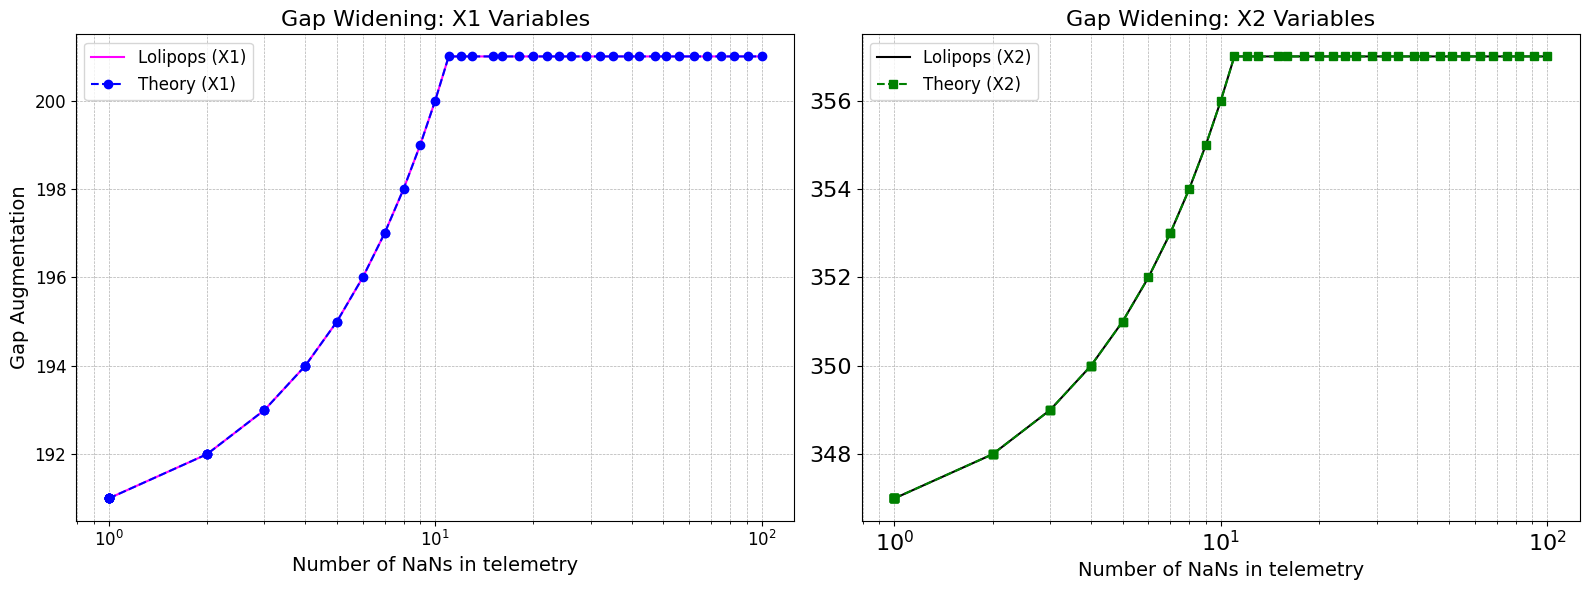

In [103]:
import matplotlib.pyplot as plt

# Extract data from results
N_nans_values = [result["N_nans"] for result in results_TDI_testing_N_nans]
widening_gap_X1_lolipops = [result["widening_gap_X1_lolipops"] for result in results_TDI_testing_N_nans]
widening_gap_X2_lolipops = [result["widening_gap_X2_lolipops"] for result in results_TDI_testing_N_nans]
widening_gap_X1_theory = [result["widening_gap_X1_theory"] for result in results_TDI_testing_N_nans]
widening_gap_X2_theory = [result["widening_gap_X2_theory"] for result in results_TDI_testing_N_nans]

# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot X1 results on the left subplot
ax1.plot(
    N_nans_values, widening_gap_X1_lolipops, 
    label="Lolipops (X1)", linestyle="-", color="magenta"
)
ax1.plot(
    N_nans_values, widening_gap_X1_theory, 
    label="Theory (X1)", linestyle="--", marker="o", color="blue"
)
ax1.set_xscale("log")
ax1.set_xlabel("Number of NaNs in telemetry", fontsize=14)
ax1.set_ylabel("Gap Augmentation", fontsize=14)
ax1.set_title("Gap Widening: X1 Variables", fontsize=16)
ax1.legend(fontsize=12, loc="upper left")
ax1.grid(True, which="both", linestyle="--", linewidth=0.5)
ax1.tick_params(axis="both", which="major", labelsize=12)

# Plot X2 results on the right subplot
ax2.plot(
    N_nans_values, widening_gap_X2_lolipops, 
    label="Lolipops (X2)", linestyle="-", color="black"
)
ax2.plot(
    N_nans_values, widening_gap_X2_theory, 
    label="Theory (X2)", linestyle="--", marker="s", color="green"
)
ax2.set_xscale("log")
ax2.set_xlabel("Number of NaNs in telemetry", fontsize=14)
# ax2.set_ylabel("Widening of Gap in X2 Variables", fontsize=14)
ax2.set_title("Gap Widening: X2 Variables", fontsize=16)
ax2.legend(fontsize=12, loc="upper left")
ax2.grid(True, which="both", linestyle="--", linewidth=0.5)
ax2.tick_params(axis="both", which="major", labelsize=16)

# Adjust layout and show the plot
plt.tight_layout()
# plt.savefig("gap_widening_comparison_TDI_subplots.png", dpi=300)  # Save as a high-resolution image
plt.show()

In [82]:
_, N_nans_in_X2_theory = widening_gap_X2(45, 1, delay)
print(N_nans_in_X2_theory - 1)

347.0


In [73]:
# Report some information about the widening of the gaps in X1 and X2 variables
print("Maximum Gap widening in X1 variables (Theory):", widening_gap_X1_theory[-1])
print("Maximum Gap widening in X2 variables (Theory):", widening_gap_X2_theory[-1])

Maximum Gap widening in X1 variables (Theory): 264.0
Maximum Gap widening in X2 variables (Theory): 437.0


In [104]:
TDI_results_by_order = {}

# Define the gap configurations and range of orders
gap_configurations = [1, 10, 25]
orders = range(25, 81, 2)  # From 25 to 81 inclusive

# Loop over each gap configuration
for N_nans in gap_configurations:
    TDI_results_by_order[N_nans] = []  # Initialize results for this gap configuration
    
    for order in tqdm(orders):
        # Construct masking function
        masking_function = construct_mask_single_gap(N_nans, length=N)
        
        # Generate telemetry with gaps
        telemetry_w_gaps, mprs_w_nans, mpr_derivatives_w_nans = nanify_telemetry_variables(
            telemetry, masking_function, plot_data=False
        )
        
        # Compute eta variables with gaps
        etas_w_gaps_nans = compute_factorized_intervars(
            telemetry_w_gaps.ifos,
            mprs_w_nans,
            mpr_derivatives_w_nans,
            telemetry.sampling,
            lagrange_interp_order=order,
        )
        
        # Compute TDI variables for two generations
        TDI_X = []
        for gen in range(1, 3):
            result = compute_factorized_michelson(
                etas_w_gaps_nans,
                mprs,
                mpr_derivatives,
                telemetry.sampling,
                generation=gen,
                lagrange_interp_order=order,
            )
            TDI_X.append(result["X"])
        
        # Calculate N_nans and widening for lolipops
        N_nans_in_TDI = [np.sum(np.isnan(TDI_X[i])) for i in range(len(TDI_X))]
        widening_gap_X1_lolipops = N_nans_in_TDI[0] - N_nans
        widening_gap_X2_lolipops = N_nans_in_TDI[1] - N_nans
        
        # Calculate N_nans and widening for theoretical model
        _, N_nans_in_X1_theory = widening_gap_X1(order, N_nans, delay)
        _, N_nans_in_X2_theory = widening_gap_X2(order, N_nans, delay)
        widening_gap_X1_theory = N_nans_in_X1_theory - N_nans
        widening_gap_X2_theory = N_nans_in_X2_theory - N_nans
        
        # Append results to the list for this gap configuration
        TDI_results_by_order[N_nans].append({
            "order": order,
            "widening_gap_X1_lolipops": widening_gap_X1_lolipops,
            "widening_gap_X2_lolipops": widening_gap_X2_lolipops,
            "widening_gap_X1_theory": widening_gap_X1_theory,
            "widening_gap_X2_theory": widening_gap_X2_theory,
        })

  0%|          | 0/28 [00:00<?, ?it/s]INFO:lolipops.constellation.tdi:Computing factorized intermediary variables
INFO:lolipops.constellation.tdi:Computing factorized second-generation Michelson variables
INFO:lolipops.constellation.tdi:Computing factorized second-generation Michelson variables
  4%|▎         | 1/28 [00:08<03:51,  8.56s/it]INFO:lolipops.constellation.tdi:Computing factorized intermediary variables
INFO:lolipops.constellation.tdi:Computing factorized second-generation Michelson variables
INFO:lolipops.constellation.tdi:Computing factorized second-generation Michelson variables
  7%|▋         | 2/28 [00:17<03:45,  8.66s/it]INFO:lolipops.constellation.tdi:Computing factorized intermediary variables
INFO:lolipops.constellation.tdi:Computing factorized second-generation Michelson variables
INFO:lolipops.constellation.tdi:Computing factorized second-generation Michelson variables
 11%|█         | 3/28 [00:26<03:47,  9.11s/it]INFO:lolipops.constellation.tdi:Computing factoriz

<Figure size 640x480 with 0 Axes>

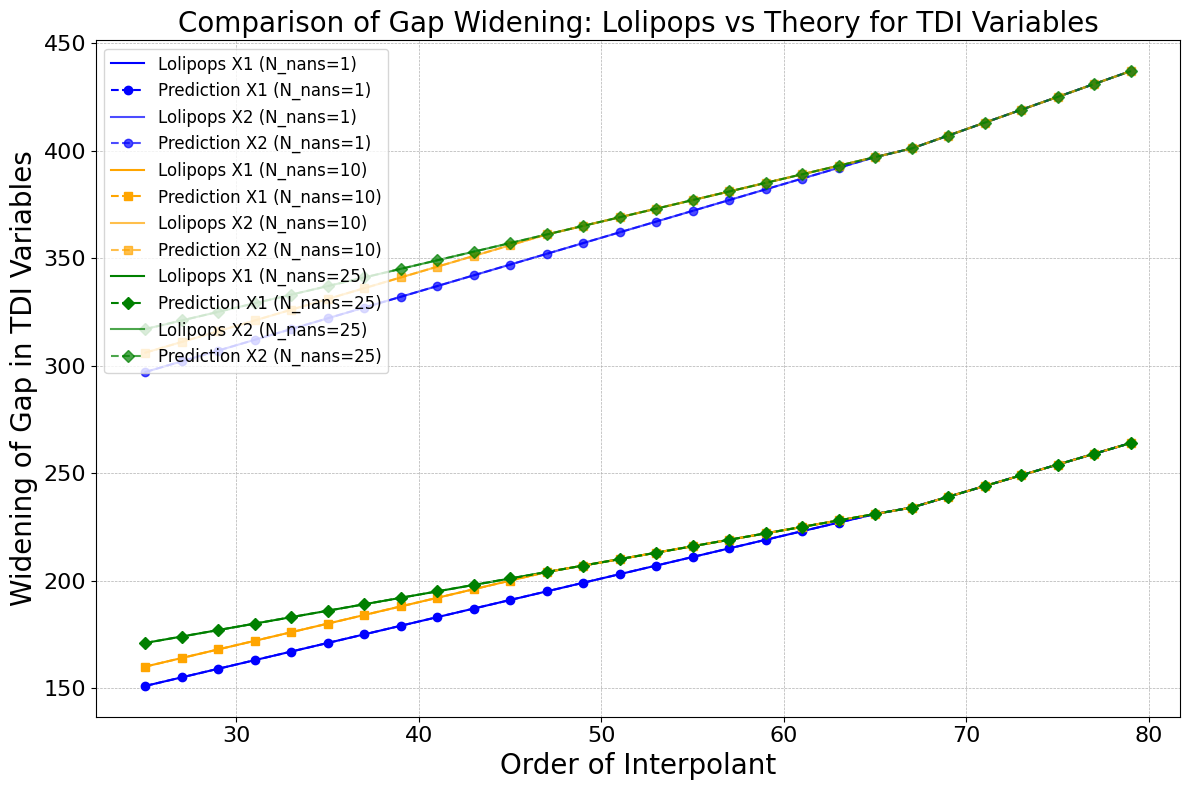

In [65]:
import matplotlib.pyplot as plt
plt.clf()
# Create a single plot for all gap configurations
plt.figure(figsize=(12, 8))

# Define markers and colors for each gap configuration
markers = ["o", "s", "D"]
colors = ["blue", "orange", "green"]

# Loop through each gap configuration and plot the results
for idx, (N_nans, results) in enumerate(TDI_results_by_order.items()):
    # Extract data for this N_nans configuration
    orders = [result["order"] for result in results]
    widening_gap_X1_lolipops = [result["widening_gap_X1_lolipops"] for result in results]
    widening_gap_X2_lolipops = [result["widening_gap_X2_lolipops"] for result in results]
    widening_gap_X1_theory = [result["widening_gap_X1_theory"] for result in results]
    widening_gap_X2_theory = [result["widening_gap_X2_theory"] for result in results]
    
    # Plot X1 results
    plt.plot(
        orders, widening_gap_X1_lolipops, 
        label=f"Lolipops X1 (N_nans={N_nans})", 
        linestyle="-", color=colors[idx], zorder=1
    )
    plt.plot(
        orders, widening_gap_X1_theory, 
        label=f"Prediction X1 (N_nans={N_nans})", 
        marker=markers[idx], linestyle="--", color=colors[idx], zorder=2
    )
    
    # Plot X2 results
    plt.plot(
        orders, widening_gap_X2_lolipops, 
        label=f"Lolipops X2 (N_nans={N_nans})", 
        linestyle="-", color=colors[idx], zorder=1, alpha=0.7
    )
    plt.plot(
        orders, widening_gap_X2_theory, 
        label=f"Prediction X2 (N_nans={N_nans})", 
        marker=markers[idx], linestyle="--", color=colors[idx], zorder=2, alpha=0.7
    )

# Add labels, legend, and grid
plt.xlabel("Order of Interpolant", fontsize=20)
plt.ylabel(r"Widening of Gap in TDI Variables", fontsize=20)
plt.title("Comparison of Gap Widening: Lolipops vs Theory for TDI Variables", fontsize=20)
plt.legend(fontsize=12, loc="upper left")
plt.grid(True, linestyle="--", linewidth=0.5)

# Increase tick sizes
plt.tick_params(axis="both", which="major", labelsize=16)

# Save and show the plot
plt.tight_layout()
# plt.savefig("gap_widening_comparison_TDI_all_configs.png", dpi=300)  # Save as a high-resolution image
plt.show()

<Figure size 640x480 with 0 Axes>

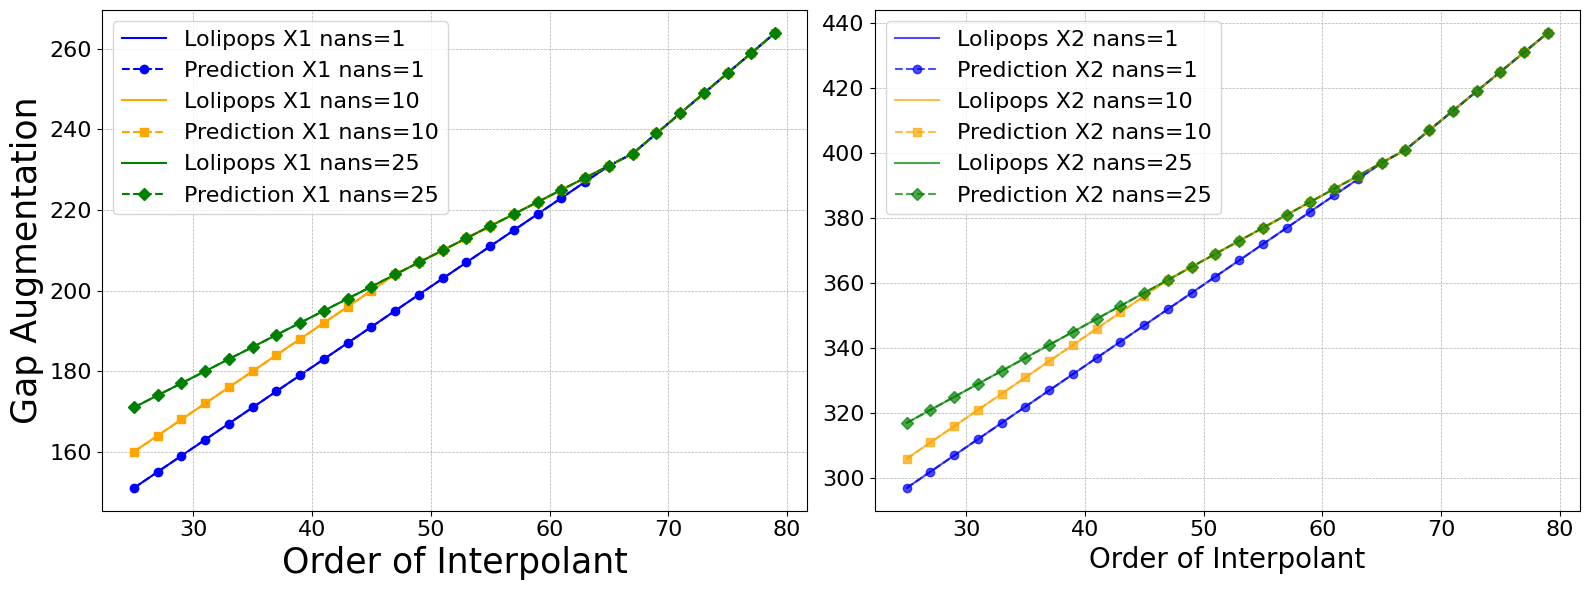

In [98]:
import matplotlib.pyplot as plt
plt.clf()

# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Define markers and colors for each gap configuration
markers = ["o", "s", "D"]
colors = ["blue", "orange", "green"]

# Loop through each gap configuration and plot the results for X1
for idx, (N_nans, results) in enumerate(TDI_results_by_order.items()):
    # Extract data for this N_nans configuration
    orders = [result["order"] for result in results]
    widening_gap_X1_lolipops = [result["widening_gap_X1_lolipops"] for result in results]
    widening_gap_X1_theory = [result["widening_gap_X1_theory"] for result in results]
    
    # Plot X1 results on the left subplot
    ax1.plot(
        orders, widening_gap_X1_lolipops, 
        label=f"Lolipops X1 nans={N_nans}", 
        linestyle="-", color=colors[idx], zorder=1
    )
    ax1.plot(
        orders, widening_gap_X1_theory, 
        label=f"Prediction X1 nans={N_nans}", 
        marker=markers[idx], linestyle="--", color=colors[idx], zorder=2
    )

# Customize the left subplot (X1)
ax1.set_xlabel("Order of Interpolant", fontsize=25)
ax1.set_ylabel(r"Gap Augmentation", fontsize=25)
# ax1.set_title(r"Gap Widening: $X_1$ Variables", fontsize=20)
ax1.legend(fontsize=16, loc="upper left")
ax1.grid(True, linestyle="--", linewidth=0.5)
ax1.tick_params(axis="both", which="major", labelsize=16)

# Loop through each gap configuration and plot the results for X2
for idx, (N_nans, results) in enumerate(TDI_results_by_order.items()):
    # Extract data for this N_nans configuration
    orders = [result["order"] for result in results]
    widening_gap_X2_lolipops = [result["widening_gap_X2_lolipops"] for result in results]
    widening_gap_X2_theory = [result["widening_gap_X2_theory"] for result in results]
    
    # Plot X2 results on the right subplot
    ax2.plot(
        orders, widening_gap_X2_lolipops, 
        label=f"Lolipops X2 nans={N_nans}", 
        linestyle="-", color=colors[idx], zorder=1, alpha=0.7
    )
    ax2.plot(
        orders, widening_gap_X2_theory, 
        label=f"Prediction X2 nans={N_nans}", 
        marker=markers[idx], linestyle="--", color=colors[idx], zorder=2, alpha=0.7
    )

# Customize the right subplot (X2)
ax2.set_xlabel("Order of Interpolant", fontsize=20)
# ax2.set_title(r"Gap Widening: $X_2$ Variables", fontsize=20)
ax2.legend(fontsize=16, loc="upper left")
ax2.grid(True, linestyle="--", linewidth=0.5)
ax2.tick_params(axis="both", which="major", labelsize=16)

# Adjust layout and show the plot
plt.tight_layout()
plt.savefig("gap_widening_comparison_TDI_subplots_change_gap_duration.png", dpi=300)  # Save as a high-resolution image
plt.show()

# The formulas check out

The formulas work extremely well for standard orders of interpolants $\mathcal{O}(L) \gtrsim 25$ providing that the missing data is contiguous. In other words, the \texttt{nans} are next to eachother. The formula *will* break down if you have multiple gaps that are very close to eachother. This is because as the nans propagate through the pipeline, the gated segments will start eating onto eachother. This means that the formula, predicting the total number of lost data will always over-estimate the loss, rather than underestimate it. This is good, we are being conservative. 

## The future goals

We will have multiple gaps of various durations. The question is how accurately (and quickly) can I predict the overall gap augmentation due to the TDI pipeline? Now I will use a generic masking function to do this. 

In [12]:
def merge_intervals(intervals):
    """Merge overlapping or adjacent intervals."""
    if not intervals:
        return []

    # Sort by start of interval
    intervals.sort(key=lambda x: x[0])
    merged = [intervals[0]]

    for current in intervals[1:]:
        prev = merged[-1]
        if current[0] <= prev[1] + 1:  # Overlapping or adjacent
            merged[-1] = (prev[0], max(prev[1], current[1]))
        else:
            merged.append(current)
    return merged

def nans_blocks_function(object_w_nans): 
    
    nan_indices = np.argwhere(np.isnan(object_w_nans)).flatten()
    if nan_indices.size == 0:
        return np.array([], dtype=int)

    # Identify contiguous NaN segments
    return np.split(nan_indices, np.where(np.diff(nan_indices) > 1)[0] + 1) 

def approx_total_nans_from_nan_blocks_eta(object_w_nans, lagrange_order=45, delay_number=1.0):
    """
    Compute the widening of gaps based on specific NaN blocks in the input vector.
    This function identifies contiguous blocks of NaNs and computes the widening for each block.
    """

    # Identify indices of NaNs
    # nan_indices = np.argwhere(np.isnan(object_w_nans)).flatten()
    # if nan_indices.size == 0:
    #     return 0, 0  # No NaNs to propagate

    # # Identify contiguous NaN segments
    # nan_blocks = np.split(nan_indices, np.where(np.diff(nan_indices) > 1)[0] + 1)

    delay = (8.333333/0.25) # Compute the delay in samples
    nan_blocks = nans_blocks_function(object_w_nans)
    # Initialize total widening and total NaNs
    total_nans = 0

    for block in nan_blocks:
        # Compute the number of NaNs in the current block
        block_size = len(block)

        # Compute widening for the current block using gap_augmentation_expression
        _, total_nans_block = gap_augmentation_expression(
            lagrange_order, block_size, delay, 1
        )

        # Accumulate results
        total_nans += total_nans_block

    return total_nans

def approx_total_nans_from_nan_blocks_X(object_w_nans, lagrange_order=45, generation = 2):
    """
    Compute the widening of gaps based on specific NaN blocks in the input vector.
    This function identifies contiguous blocks of NaNs and computes the widening for each block.
    """

    # Identify indices of NaNs
    # nan_indices = np.argwhere(np.isnan(object_w_nans)).flatten()
    # if nan_indices.size == 0:
    #     return 0, 0  # No NaNs to propagate

    # # Identify contiguous NaN segments
    # nan_blocks = np.split(nan_indices, np.where(np.diff(nan_indices) > 1)[0] + 1)

    delay = (8.333333/0.25) # Compute the delay in samples
    nan_blocks = nans_blocks_function(object_w_nans)
    # Initialize total widening and total NaNs
    total_widening = 0
    total_nans = 0

    for block in nan_blocks:
        # Compute the number of NaNs in the current block
        block_size = len(block)

        # Compute widening for the current block using gap_augmentation_expression
        if generation == 1:
            _, total_nans_block = widening_gap_X1(lagrange_order, block_size, delay)
        elif generation == 2:
            _, total_nans_block = widening_gap_X2(lagrange_order, block_size, delay)

        # Accumulate results
        total_nans += total_nans_block

    return int(total_nans)
def compute_nan_indices_delay(object_w_nans, delay=33, order=45):
    """
    Generalized function to compute eta NaN indices due to multiple telemetry NaN gaps,
    with interval merging to avoid overlaps.
    """

    # nan_indices = np.argwhere(np.isnan(object_w_nans)).flatten()
    # N_original_series = len(object_w_nans)
    # if nan_indices.size == 0:
    #     return np.array([], dtype=int)

    # # Identify contiguous NaN segments
    # nan_blocks = np.split(nan_indices, np.where(np.diff(nan_indices) > 1)[0] + 1)

    N_original_series = len(object_w_nans)
    nan_blocks = nans_blocks_function(object_w_nans)

    # Store all intervals affected
    affected_intervals = []

    p = int((order + 1) / 2)

    for block in nan_blocks:
        n_object_first = block[0]
        n_object_last = block[-1]

        # Direct NaNs
        direct_start = n_object_first
        direct_end = n_object_last

        # Delayed NaNs (inclusive)
        delay_start = n_object_first + delay - p + 1
        delay_end = n_object_last + delay - (1 - p) + 1

        affected_intervals.append((direct_start, direct_end))
        affected_intervals.append((delay_start, delay_end))

    # Merge overlapping/adjacent intervals
    merged_intervals = merge_intervals(affected_intervals)

    # Generate unique indices from merged intervals
    affected_indices = np.concatenate([
        np.arange(start, end + 1) for start, end in merged_intervals
    ])

    affected_indices = affected_indices[(affected_indices >= 0) & (affected_indices < N_original_series)]
    affected_indices = np.unique(affected_indices)

    # # Create eta mask array: 1s and NaNs
    new_mask_like_array = np.ones_like(object_w_nans, dtype=float)
    new_mask_like_array[affected_indices] = np.nan

    return  new_mask_like_array

def mask_eta(mask_telemetry, delay = 33, order = 45, generation = 2):
    delay = 8.33333/0.25
    new_mask_like_array_eta = compute_nan_indices_delay(mask_telemetry, delay = int(np.floor(delay)), order=order)

    return new_mask_like_array_eta
    
def mask_TDI_X(mask_telemetry, order = 45, generation = 2):
    delay = 8.33333/0.25
    new_mask_like_array_eta = compute_nan_indices_delay(mask_telemetry, delay = int(np.floor(delay)), order=order)
    new_mask_like_array_a12 = compute_nan_indices_delay(new_mask_like_array_eta, delay= int(np.floor(delay)), order=order)
    new_mask_like_array_r12 = compute_nan_indices_delay(new_mask_like_array_a12, delay= int(np.floor(2*delay)), order=order)  

    if generation == 1:
        return new_mask_like_array_r12
    else:
        new_mask_like_array_q21 = compute_nan_indices_delay(new_mask_like_array_r12, delay= int(np.floor(4*delay)), order=45) 
        return new_mask_like_array_q21

# Define the overall masking function

The masking function will take in a dictionary of gating functions

In [18]:
# Generate the mask with sampling interval 0.25 seconds

# Define the gap function 

# Construct gap class

N = telemetry.sampling.size
t_start = telemetry.sampling.t0

sim_t = np.arange(0, N * telemetry.sampling.dt, telemetry.sampling.dt)

gap_definitions = {
    "planned": {
        "antenna repointing": {"rate_per_year": 2*260, "duration_hr": 3.3},
        # "TM stray potential": {"rate_per_year": 2, "duration_hr": 24},
        # "TTL calibration": {"rate_per_year": 4, "duration_hr": 48},
        # "PAAMs": {"rate_per_year": 1095, "duration_hr": 0.028}, # 2 second
        # "Aliens": {"rate_per_year": 6, "duration_hr": 30*24}
    },
    "unplanned": {
        "platform safe mode": {"rate_per_year": 3, "duration_hr": 60},
        # "payload safe mode": {"rate_per_year": 4, "duration_hr": 66},
        # "QPD loss micrometeoroid": {"rate_per_year": 5, "duration_hr": 24},
        # "HR GRS loss micrometeoroid": {"rate_per_year": 19, "duration_hr": 24},
        # "WR GRS loss micrometeoroid": {"rate_per_year": 6, "duration_hr": 24},
        # "Unknown": {"rate_per_year": 100_000, "duration_hr": 2/(60*60)}, # 2 second
    }
}

# Initialise class with rates, and sampling properties.
generator = GapMaskGenerator(
    sim_t,
    dt,
    gap_definitions,
    treat_as_nan=True,
    planseed=11_07_1993,
    unplanseed = 16_12_1997
)

# Generate the mask full of gaps
full_mask = generator.generate_mask(include_unplanned=False, include_planned=True)

extract_summary = generator.summary(mask = full_mask)
from pprint import pprint
pprint(extract_summary['mask_analysis'])

{'duty_cycle_percent': np.float64(80.5673),
 'number_of_gap_segments': 1135,
 'total_gap_hours': np.float64(3720.28),
 'total_gap_samples': 133930}


In [19]:
# Let's compute the true number of nans in the eta variables
N_nans_multiple_gaps = np.sum(np.isnan(full_mask))

order = 45
telemetry_w_multi_gaps, mprs_w_mult_gaps, mpr_derivatives_w_multi_gaps = nanify_telemetry_variables(telemetry, full_mask, plot_data = False)
etas_w_multi_gaps = compute_factorized_intervars(
    telemetry_w_multi_gaps.ifos,
    mprs_w_mult_gaps,
    mpr_derivatives_w_multi_gaps,
    telemetry.sampling,
    lagrange_interp_order=order,
)

print("Doing things using lolipops")
N_nans_in_eta_w_multi_gaps_lolipops = np.sum(np.isnan(etas_w_multi_gaps["eta_12"]))
widening_gap_eta_lolipops = N_nans_in_eta_w_multi_gaps_lolipops - N_nans_multiple_gaps
print("Number of nans in the eta variables = ", N_nans_in_eta_w_multi_gaps_lolipops)
print("Overall widening of gap in eta variables = ", widening_gap_eta_lolipops)
print("Now doing things carefully but using theory")

# Now compute the maksing function for the eta variables using my formulas
eta_mask = mask_eta(full_mask, delay=8.33333/0.25, order=45)

N_nans_in_eta_w_multi_gaps_theory = np.sum(np.isnan(eta_mask))
widening_gap_eta_theory = N_nans_in_eta_w_multi_gaps_theory - N_nans_multiple_gaps
print("Number of nans in the eta variables = ", N_nans_in_eta_w_multi_gaps_theory)
print("Overall widening of gap in eta variables = ", widening_gap_eta_theory)

# Can I try to approximate this result?
print("Now using our quick approximation formula")
approx_nans_in_eta = approx_total_nans_from_nan_blocks_eta(full_mask, lagrange_order=45, delay_number=1.0)

approx_N_nans_in_eta_w_multi_gaps_theory = np.sum(np.isnan(eta_mask))
approx_widening_gap_eta_theory = approx_N_nans_in_eta_w_multi_gaps_theory - N_nans_multiple_gaps
print("Approx number of nans in the eta variables = ", approx_N_nans_in_eta_w_multi_gaps_theory)
print("Overall widening of gap in eta variables = ", approx_widening_gap_eta_theory)



INFO:lolipops.constellation.tdi:Computing factorized intermediary variables


Doing things using lolipops
Number of nans in the eta variables =  197490
Overall widening of gap in eta variables =  63560
Now doing things carefully but using theory
Number of nans in the eta variables =  197490
Overall widening of gap in eta variables =  63560
Now using our quick approximation formula
Approx number of nans in the eta variables =  197490
Overall widening of gap in eta variables =  63560


# Try to do the same thing but with TDI X variables for both generations

In [22]:
# Let's compute the true number of nans in the telemetry gaps
N_nans_multiple_gaps = np.sum(np.isnan(full_mask))

order = 45
telemetry_w_multi_gaps, mprs_w_mult_gaps, mpr_derivatives_w_multi_gaps = nanify_telemetry_variables(telemetry, full_mask, plot_data=False)
etas_w_multi_gaps = compute_factorized_intervars(
    telemetry_w_multi_gaps.ifos,
    mprs_w_mult_gaps,
    mpr_derivatives_w_multi_gaps,
    telemetry.sampling,
    lagrange_interp_order=order,
)

# Compute TDI variables for generation 1 and generation 2
TDI_X = []
for gen in range(1, 3):
    result = compute_factorized_michelson(
        etas_w_multi_gaps,
        mprs_w_mult_gaps,
        mpr_derivatives_w_multi_gaps,
        telemetry.sampling,
        generation=gen,
        lagrange_interp_order=order,
    )
    TDI_X.append(result["X"])


INFO:lolipops.constellation.tdi:Computing factorized intermediary variables
INFO:lolipops.constellation.tdi:Computing factorized second-generation Michelson variables
INFO:lolipops.constellation.tdi:Computing factorized second-generation Michelson variables


In [24]:

print("Using loliipops")
N_nans_in_X1_w_multi_gaps_lolipops = np.sum(np.isnan(TDI_X[0]))
N_nans_in_X2_w_multi_gaps_lolipops = np.sum(np.isnan(TDI_X[1]))

widening_gap_X1_lolipops = N_nans_in_X1_w_multi_gaps_lolipops - N_nans_multiple_gaps
widening_gap_X2_lolipops = N_nans_in_X2_w_multi_gaps_lolipops - N_nans_multiple_gaps
print("lolipops: Number of nans in X1 variables = ", N_nans_in_X1_w_multi_gaps_lolipops)
print("lolipops: Widening of gap in X1 variables = ", widening_gap_X1_lolipops)
print("lolipops: Number of nans in X2 variables = ", N_nans_in_X2_w_multi_gaps_lolipops)
print("lolipops: Widening of gap in X2 variables = ", widening_gap_X2_lolipops)

print("")
print("Now doing things carefully but using theory")
print("")

# Compute the masking function for X1 and X2 variables using formulas
X1_mask = mask_TDI_X(full_mask, order=45, generation=1)
X2_mask = mask_TDI_X(full_mask, order=45, generation=2)

N_nans_in_X1_w_multi_gaps_theory = np.sum(np.isnan(X1_mask))
N_nans_in_X2_w_multi_gaps_theory = np.sum(np.isnan(X2_mask))
widening_gap_X1_theory = N_nans_in_X1_w_multi_gaps_theory - N_nans_multiple_gaps
widening_gap_X2_theory = N_nans_in_X2_w_multi_gaps_theory - N_nans_multiple_gaps
print("Theory: Number of nans in X1 variables = ", N_nans_in_X1_w_multi_gaps_theory)
print("Theory: Widening of gap in X1 variables = ", widening_gap_X1_theory)
print("Theory: Number of nans in X2 variables = ", N_nans_in_X2_w_multi_gaps_theory)
print("Theory: Widening of gap in X2 variables = ", widening_gap_X2_theory)
print("")
# Can I try to approximate this result?
print("Now using our quick approximation formula")
print("")
approx_nans_in_X1 = approx_total_nans_from_nan_blocks_X(full_mask, lagrange_order=45, generation=1)
approx_nans_in_X2 = approx_total_nans_from_nan_blocks_X(full_mask, lagrange_order=45, generation=2)

approx_N_nans_in_X1_w_multi_gaps_theory = np.sum(np.isnan(X1_mask))
approx_N_nans_in_X2_w_multi_gaps_theory = np.sum(np.isnan(X2_mask))
approx_widening_gap_X1_theory = approx_N_nans_in_X1_w_multi_gaps_theory - N_nans_multiple_gaps
approx_widening_gap_X2_theory = approx_N_nans_in_X2_w_multi_gaps_theory - N_nans_multiple_gaps
print("Approx: Number of nans in X1 variables = ", approx_N_nans_in_X1_w_multi_gaps_theory)
print("Approx:  Widening of gap in X1 variables = ", approx_widening_gap_X1_theory)
print("Approx: Number of nans in X2 variables = ", approx_N_nans_in_X2_w_multi_gaps_theory)
print("Approx:  Widening of gap in X2 variables = ", approx_widening_gap_X2_theory)

Using loliipops
lolipops: Number of nans in X1 variables =  362065
lolipops: Widening of gap in X1 variables =  228135
lolipops: Number of nans in X2 variables =  539059
lolipops: Widening of gap in X2 variables =  405129

Now doing things carefully but using theory

Theory: Number of nans in X1 variables =  362065
Theory: Widening of gap in X1 variables =  228135
Theory: Number of nans in X2 variables =  539059
Theory: Widening of gap in X2 variables =  405129

Now using our quick approximation formula

Approx: Number of nans in X1 variables =  362065
Approx:  Widening of gap in X1 variables =  228135
Approx: Number of nans in X2 variables =  539059
Approx:  Widening of gap in X2 variables =  405129


# Things check out with lolipops
I have checked that the overall number of nans (and nan placements) agree with what comes out of lolipops. I should go through this in more detail, but there is no point at the moment. 

# Telemetry variables fail at the same time, stop this?

Perhaps it would be a useful research study to investigate the impact of nultiple telemetry variables failing at the same time. Can we apply a similar strategy to figure this out?





In [ ]:
telemetry.ifos[""]